<h1 align="center"> Geometric Methods in ML - ENSAE 2016/2017 </h1>
<h2 align="center"> Kernels approximation with Random Features </h2>
<h4 align="right"> <i>Author: Hicham Janati </i></h4>

<hr> 

This notebook uses the RFF class implemented in <a href="RFF-II.ipynb"> RFF - Notebook I </a> to perform SVM classification on real data.


In [1]:
import numpy as np # Thinly−wrapped numpy
import pandas as pd
from matplotlib import cm 
import matplotlib as mpl
%matplotlib inline 
from matplotlib import pyplot as plt 
data = '../data/'

Import the RFF object:

In [2]:
from RFF import*

# Experiments II
In the following section, using USPS and Gisette datasets we:
- Evaluate RF approximation quality:
    1. MSE(Approximated Kernel, True Kernel)
    
    **2. Computation time & SVM accuracy **


#### Load data

In [3]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import ShuffleSplit,  GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

digits = fetch_mldata("USPS")
X_usps, y_usps = digits.data, digits.target.astype(int) - 1

X_gis = pd.read_csv(data + "gisette/X_train.txt",sep=' ',header=None).drop([5000],axis=1).values
y_gis = pd.read_csv(data + "gisette/y_train.txt",header=None).values.flatten()

print("USPS: X.shape = {} | y.shape = {} | number of classes : {}".format(X_usps.shape, y_usps.shape, len(np.unique(y_usps))))
print("Gisette: X.shape = {} | y.shape = {} | number of classes : {}".format(X_gis.shape, y_gis.shape, len(np.unique(y_gis))))


USPS: X.shape = (9298, 256) | y.shape = (9298,) | number of classes : 10
Gisette: X.shape = (6000, 5000) | y.shape = (6000,) | number of classes : 2


### 1 - USPS

In [4]:
X , y = X_usps.copy(), y_usps.copy()
#X , y = X_gis.copy(), y_gis.copy()

Split the data:

In [5]:
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=123)  
train_is, test_is = list(skf.split(X))[0]
X_train = X[train_is].copy()                                  
y_train = y[train_is].copy()
X_test = X[test_is].copy()                                    
y_test = y[test_is].copy() 

In [6]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from time import time

n_features = X.shape[1]
gamma = 1/n_features


exact_svm1 = Pipeline([
                      ('std',StandardScaler()),
                      ('svc', OneVsRestClassifier(SVC(C=5, kernel="rbf"))),
                      ])

t = time()
exact_svm1.fit(X_train,y_train)
t_exact1 = time() - t

# Test 
y_pred1 = exact_svm1.predict(X_test)                      
error1 = 1 - accuracy_score(y_test, y_pred1)                       
print('Testing error exact SVM = %f | training time = %.3f' %(error1, t_exact1))                                                                            


Testing error exact SVM = 0.019355 | training time = 14.998


In [19]:
Ds = [2**i for i in range(5,14)]
lDs = len(Ds)
n_repeats = 10
rff_times1, rff_errors1 = np.zeros((lDs,n_repeats)), np.zeros((lDs,n_repeats))

for i,D in enumerate(Ds):
    print(D)
    rff_pip1 = Pipeline([
                ('std',StandardScaler()),
                ('rff',RFF(gamma=gamma, metric = 'rbf', D=D)),
                ('linsvc', OneVsRestClassifier(LinearSVC(C=5))),
             ])

    for n in range(n_repeats):
        t = time()
        rff_pip1.fit(X_train, y_train)
        t_rff1 = time() - t
        rff_times1[i,n] = t_rff1

        y_pred_rff1 = rff_pip1.predict(X_test)                      
        error_rff1 = 1 - accuracy_score(y_test, y_pred_rff1) 
        rff_errors1[i,n] = error_rff1

np.save(data+'rff_usps_errors', rff_errors1)
np.save(data+'rff_usps_times', rff_times1)

print("Best RFF performance: Testing error = %f | Training time = %.3f"%(rff_errors1[-1,-1],rff_times1[-1,-1]))

32
64
128
256
512
1024
2048
4096
8192
Best RFF performance: Testing error = 0.053333 | Training time = 16.308


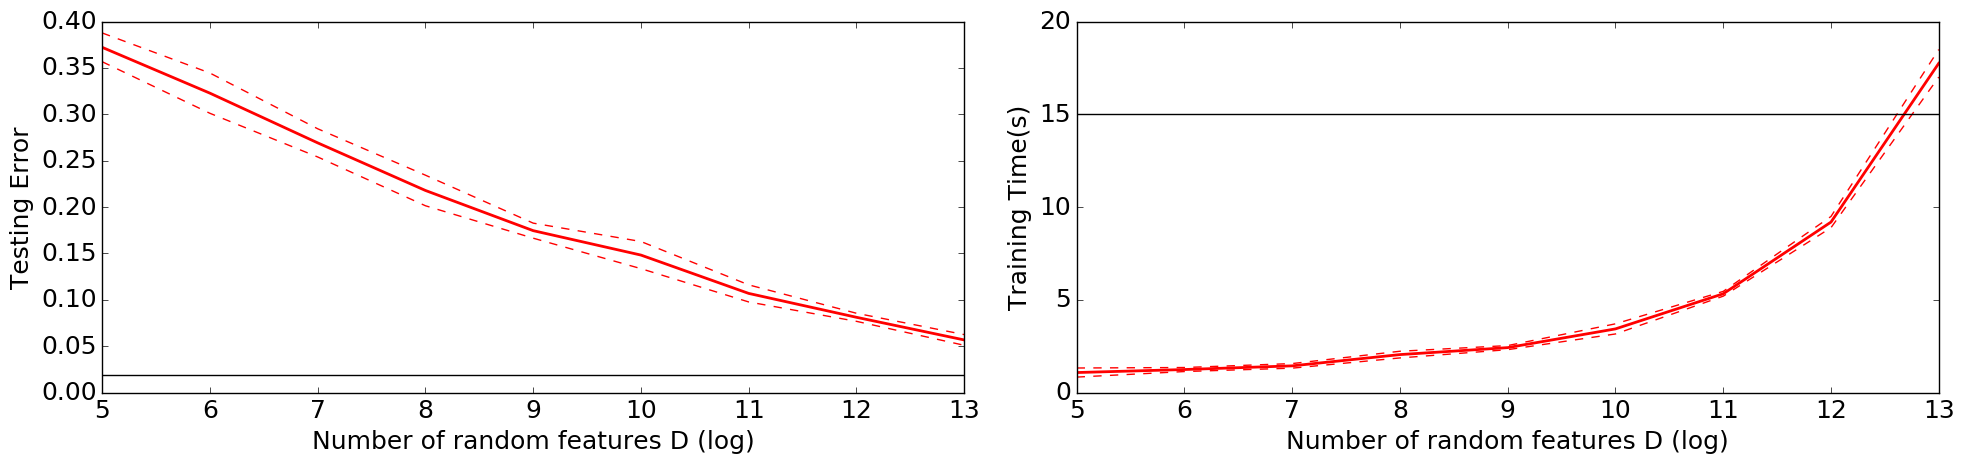

In [42]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages("svm_usps.pdf")
logDs = np.arange(5,14)
mpl.rcParams.update({'font.size': 18})
f = plt.figure(figsize=(20,5))
plt.subplot(121)
mean = rff_errors1.mean(axis=-1)
std = rff_errors1.std(axis=-1)
plt.plot(logDs, mean, 'r', linewidth = 2,label="RFF + LinSVM")
plt.plot(logDs, mean-std, 'r--')
plt.plot(logDs, mean+std, 'r--')

plt.plot(logDs, len(Ds)*[error1],'k', label="Kernel SVM")
plt.ylabel("Testing Error")
plt.xlabel("Number of random features D (log)")

plt.subplot(122)
mean = rff_times1.mean(axis=-1)
std = rff_times1.std(axis=-1)
plt.plot(logDs, mean, 'r', linewidth=2, label="RFF + LinSVM")
plt.plot(logDs, mean-std, 'r--')
plt.plot(logDs, mean+std, 'r--')
plt.plot(logDs, len(Ds)*[t_exact1],'k', label="Kernel SVM")
plt.ylabel("Training Time(s)")
plt.xlabel("Number of random features D (log)")
#plt.legend(bbox_to_anchor=[1.4,1.])
plt.tight_layout()
pp.savefig(f)
pp.close()
plt.show()

### 2 - Gisette

In [8]:
#X , y = X_usps.copy(), y_usps.copy()
X , y = X_gis.copy().astype(float), y_gis.copy().astype(float)

Split the data:

In [9]:
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=123)  
train_is, test_is = list(skf.split(X))[0]
X_train = X[train_is].copy()                                  
y_train = y[train_is].copy()
X_test = X[test_is].copy()                                    
y_test = y[test_is].copy() 

In [10]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from time import time

n_features = X.shape[1]
gamma = 1/n_features


exact_svm2 = Pipeline([
                      ('std',StandardScaler()),
                      ('svc', OneVsRestClassifier(SVC(C=5, kernel="rbf"))),
                      ])

t = time()
exact_svm2.fit(X_train,y_train)
t_exact2 = time() - t

# Test 
y_pred2 = exact_svm2.predict(X_test)                      
error2 = 1 - accuracy_score(y_test, y_pred2)                       
print('Testing error exact SVM = %f | training time = %.3f' %(error2, t_exact2))                                                                            


Testing error exact SVM = 0.028333 | training time = 65.331


In [20]:
Ds = [2**i for i in range(5,14)]
lDs = len(Ds)
n_repeats = 10
rff_times2, rff_errors2 = np.zeros((lDs,n_repeats)), np.zeros((lDs,n_repeats))

for i,D in enumerate(Ds):
    rff_pip2 = Pipeline([
                ('std',StandardScaler()),
                ('rff',RFF(gamma=gamma, metric = 'rbf', D=D)),
                ('linsvc', OneVsRestClassifier(LinearSVC(C=5))),
             ])

    for n in range(n_repeats):
        t = time()
        rff_pip2.fit(X_train, y_train)
        t_rff2 = time() - t
        rff_times2[i,n] = t_rff2

        y_pred_rff2 = rff_pip2.predict(X_test)                      
        error_rff2 = 1 - accuracy_score(y_test, y_pred_rff2) 
        rff_errors2[i,n] = error_rff2

np.save(data+'rff_gis_errors', rff_errors2)
np.save(data+'rff_gis_times', rff_times2)

print("Best RFF performance: Testing error = %f | Training time = %.3f"%(rff_errors2[-1,-1],rff_times2[-1,-1]))

Best RFF performance: Testing error = 0.053333 | Training time = 17.602


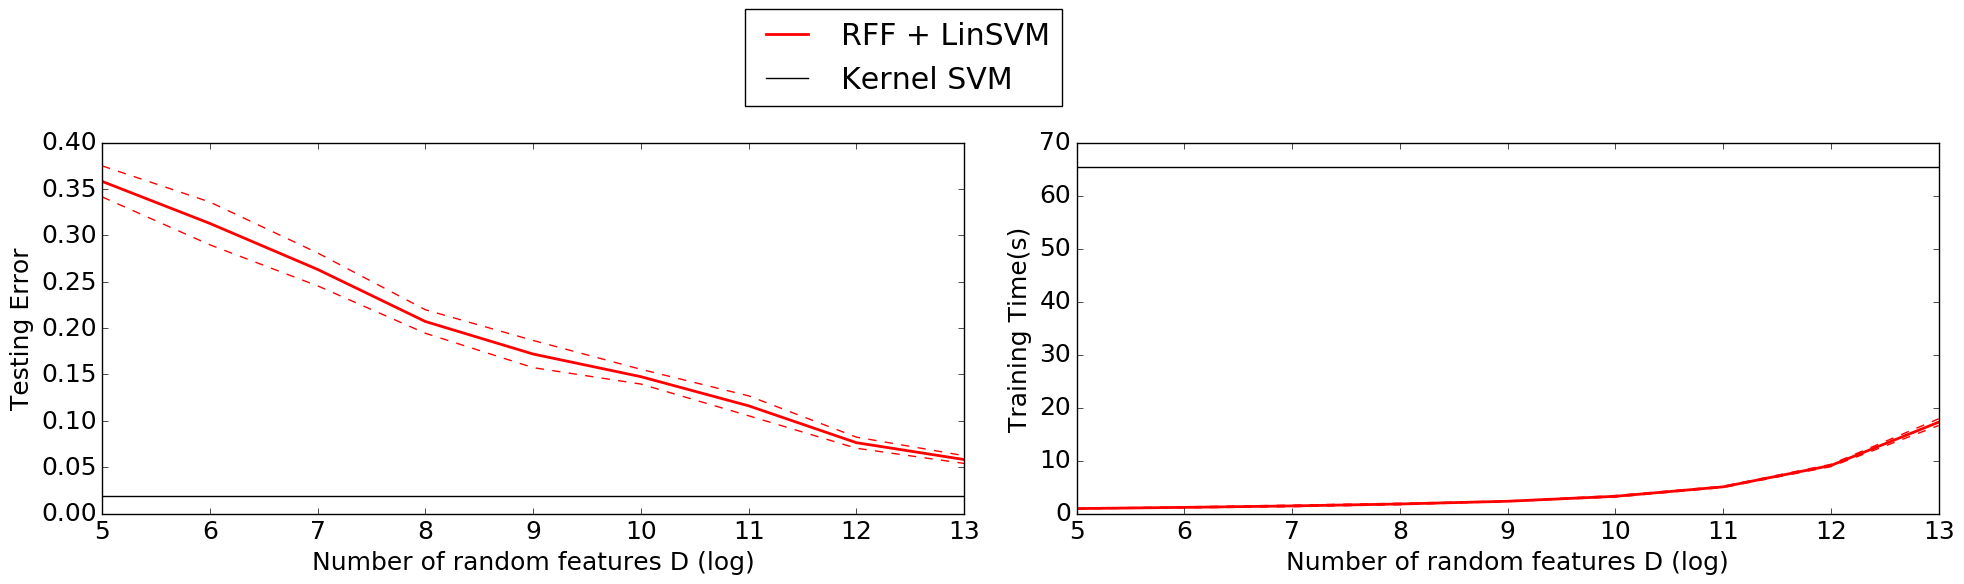

In [45]:
logDs = np.arange(5,14)
pp = PdfPages("svm_gis.pdf")
mpl.rcParams.update({'font.size': 18})
f = plt.figure(figsize=(20,5))
plt.subplot(121)
mean = rff_errors2.mean(axis=-1)
std = rff_errors2.std(axis=-1)
plt.plot(logDs, mean, 'r', linewidth = 2,label="RFF + LinSVM")
plt.plot(logDs, mean-std, 'r--')
plt.plot(logDs, mean+std, 'r--')

plt.plot(logDs, len(Ds)*[error1],'k', label="Kernel SVM")
plt.ylabel("Testing Error")
plt.xlabel("Number of random features D (log)")

plt.subplot(122)
mean = rff_times2.mean(axis=-1)
std = rff_times2.std(axis=-1)
plt.plot(logDs, mean, 'r', linewidth=2, label="RFF + LinSVM")
plt.plot(logDs, mean-std, 'r--')
plt.plot(logDs, mean+std, 'r--')
plt.plot(logDs, len(Ds)*[t_exact2],'k', label="Kernel SVM")
plt.ylabel("Training Time(s)")
plt.xlabel("Number of random features D (log)")
plt.legend(bbox_to_anchor=[0,1.4])
plt.tight_layout()
pp.savefig(f)
pp.close()
plt.show()

# In the Next Notebook: 
- Implementation of SRF (for polynomial Kernels) first class (ApproxKernel) that approximates the polynomial kernel function by a surrogate function on which the Bochner theorem can be applied. 

 <a href="SRF-I.ipynb"> Go to the next notebook </a>